## Introduction
The dataset I am using is a Netflix dataset containing a designated show id, title, director, cast, country, date it was added to Netflix, release year, rating, duration, the genres that it is listed in, and a small show sypnopsis. From here, the goal is to look at the movie/show data and analyze it, giving insights into some basic summary statistics and visualizations alongside answering the following questions: 
* Are TV shows trending toward longer or shorter seasons
* compare average release year
* genre diversity or number of entries
* explore how genres have shifted over time.

To do this, I will first prep the data by cleaning it and perform exploratory data analysis to answer these questions. 


In [12]:
## imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


## 1 Data Cleaning/Prep and Structure

In [13]:
## read data

netflix = pd.read_csv("Netflix.csv")
print(netflix['rating'].value_counts())
print(netflix['duration'].value_counts())
netflix.head()


rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64
duration
1 Season     1793
2 Seasons     425
3 Seasons     199
90 min        152
97 min        146
             ... 
228 min         1
18 min          1
205 min         1
201 min         1
191 min         1
Name: count, Length: 220, dtype: int64


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Here, we can see that there are many rating categories and some are slighlty repetitive such as TV-Y7 and TV-Y7-FV as the additional FV just means that it includes fantasy violence. We can change the FV category to just be TV-Y7. Also there seems to be some misplaced values of duration in the rating row (74 min, 84 min, 66 min) so we can remove these values. To make things easier to work with, I will just have the correct ratings and also separate tv shows and movies as separate data frames. 

We can also see that there are 7 null values in the dataset that matter (which is for rating and duration). In this case, the three rows that have a integer value of duration in minutes for rating is actually misplaced as their duration row has no value/is null. So from here, I moved the values in rating to duration to accurately place them where they belong. And there are 4 null values for rating which will will change to unrated ('UR') to consolidate the data.

In [14]:
netflix['rating'] = netflix['rating'].replace('TV-Y7-FV', 'TV-Y7') # combine tv-y7 and tv-y7-fv also checks out because tv-y7 is now 340 values (added 6 from fv)
netflix['rating'] = netflix['rating'].replace('UR', 'NR') #combine not rated and unrated


## check for null values and put the duration values in rating back in the right place
print(netflix.isnull().sum())
netflix[netflix[['rating', 'duration']].isnull().any(axis = 1)]
indexes = netflix[netflix['rating'].str.contains('min', na = False)].index
print(indexes)

netflix.loc[indexes, 'duration'] = netflix.loc[indexes, 'rating']

#replace integer values of rating into NR
netflix.loc[indexes, 'rating'] = 'NR'

netflix[netflix[['rating', 'duration']].isnull().any(axis = 1)]

##change the 4 nan values from rating to NR
ratingindex = netflix[netflix['rating'].isnull()].index
netflix.loc[ratingindex, 'rating'] = 'NR'

netflix['rating'].value_counts()




show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64
Index([5541, 5794, 5813], dtype='int64')


rating
TV-MA    3207
TV-14    2160
TV-PG     863
R         799
PG-13     490
TV-Y7     340
TV-Y      307
PG        287
TV-G      220
NR         90
G          41
NC-17       3
Name: count, dtype: int64

It also appears that for movies theres a duration of single minutes, but for tv shows the duration is done in seasons, not length in minutes. This is generally fine, but I want to change the datatypes into an integer type, so I will check if all tv shows have the word 'season' in it and if they do I should be good to just change it into a numeric value. Rather than change the column, I want to preserve the original column values, so I will separate netflix movies and tv shows into two separate variables and analyze them from there so I can do separate analysis and combined analysis if necessary. I will also create a new column in the two new netflix dataframe variables called int_duration and for movies this will represent the movie length in minutes but for tv shows it will represent number of seasons.

In [15]:
tv_ratings = ['TV-MA', 'TV-14', 'TV-PG', 'TV-Y7', 'TV-Y', 'TV-G']
movie_ratings = ['R', 'PG-13', 'PG', 'G', 'NC-17', 'UR']

##separate tv and movie
netflix_movies = netflix[(netflix['type'] == 'Movie') & (netflix['rating'].isin(movie_ratings))].copy()

netflix_tv = netflix[(netflix['type'] == 'TV Show')& (netflix['rating'].isin(tv_ratings))].copy()

## check to see if all tv shows are measured by seasons
all_seasons = netflix_tv['duration'].str.contains('Season', na = False).all()
print(all_seasons)

## add new numeric column to look at all duration values as integers 
netflix_movies['int_duration (minutes)'] = netflix_movies['duration'].str.extract(r'(\d+)').astype(int)

netflix_tv['int_duration (seasons)'] = netflix_tv['duration'].str.extract(r'(\d+)').astype(int)


True


Next I should also convert the release_year and date_added into a datetime object. I also need to explode/separate the data into its separate genres so evaluate genre trends. Object is pretty vague so I will convert each category into its appropriate type as well.

In [25]:
#explode the genre
netflix_movies['genre'] = netflix_movies['listed_in'].str.split(', ')
netflix_movies_exploded = netflix_movies.explode('genre')
netflix_tv['genre'] = netflix_tv['listed_in'].str.split(', ')
netflix_tv_exploded = netflix_tv.explode('genre')

netflix_tv_exploded['genre'].value_counts() # check genres
netflix_movies_exploded['genre'].value_counts()


netflix_tv_exploded['date_added'].isnull().sum() #check null values and address them
netflix_tv_exploded[netflix_tv_exploded['date_added'].isnull()]

netflix_movies_exploded.dtypes
netflix_tv_exploded.dtypes

nullindex = netflix_tv_exploded[netflix_tv_exploded['date_added'].isnull()]


In [17]:
#convert date to datetime
netflix_movies_exploded['date_added'] = netflix_movies_exploded['date_added'].astype(str).str.strip() ## pd.datetime converted values to NaT incorrectly so i tried stripping whitespace (it worked)
netflix_tv_exploded['date_added'] = netflix_tv_exploded['date_added'].astype(str).str.strip()
netflix_movies_exploded['date_added'] = pd.to_datetime(netflix_movies_exploded['date_added'], errors='coerce')
netflix_movies_exploded['release_year'] = pd.to_datetime(netflix_movies_exploded['release_year'], format='%Y', errors='coerce')
netflix_tv_exploded['date_added'] = pd.to_datetime(netflix_tv_exploded['date_added'], errors='coerce')
netflix_tv_exploded['release_year'] = pd.to_datetime(netflix_tv_exploded['release_year'], format='%Y', errors='coerce')

#change type for movies
netflix_movies_exploded['show_id'] = netflix_movies_exploded['show_id'].astype('string')
netflix_movies_exploded['type'] = netflix_movies_exploded['type'].astype('category')
netflix_movies_exploded['title'] = netflix_movies_exploded['title'].astype('string')
netflix_movies_exploded['director'] = netflix_movies_exploded['director'].astype('string')
netflix_movies_exploded['cast'] = netflix_movies_exploded['cast'].astype('string')
netflix_movies_exploded['country'] = netflix_movies_exploded['country'].astype('category')
netflix_movies_exploded['rating'] = netflix_movies_exploded['rating'].astype('category')
netflix_movies_exploded['duration'] = netflix_movies_exploded['duration'].astype('string')
netflix_movies_exploded['listed_in'] = netflix_movies_exploded['listed_in'].astype('string')
netflix_movies_exploded['description'] = netflix_movies_exploded['description'].astype('string')
netflix_movies_exploded['genre'] = netflix_movies_exploded['genre'].astype('category')

#change type for tv shows
netflix_tv_exploded['show_id'] = netflix_tv_exploded['show_id'].astype('string')
netflix_tv_exploded['type'] = netflix_tv_exploded['type'].astype('category')
netflix_tv_exploded['title'] = netflix_tv_exploded['title'].astype('string')
netflix_tv_exploded['director'] = netflix_tv_exploded['director'].astype('string')
netflix_tv_exploded['cast'] = netflix_tv_exploded['cast'].astype('string')
netflix_tv_exploded['country'] = netflix_tv_exploded['country'].astype('category')
netflix_tv_exploded['rating'] = netflix_tv_exploded['rating'].astype('category')
netflix_tv_exploded['duration'] = netflix_tv_exploded['duration'].astype('string')
netflix_tv_exploded['listed_in'] = netflix_tv_exploded['listed_in'].astype('string')
netflix_tv_exploded['description'] = netflix_tv_exploded['description'].astype('string')
netflix_tv_exploded['genre'] = netflix_tv_exploded['genre'].astype('category')

# netflix_tv_exploded[netflix_tv_exploded['date_added'].isnull()] #this coode checks for null values

## 2/3 Exploratory Data Analysis and Visualization

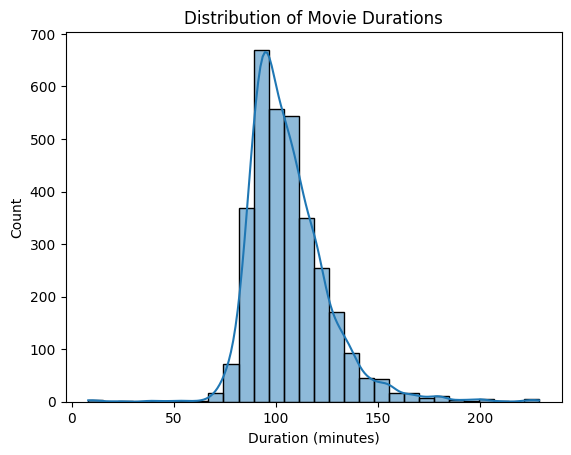

count    3263.000000
mean      106.046583
std        19.300783
min         8.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       229.000000
Name: int_duration (minutes), dtype: float64


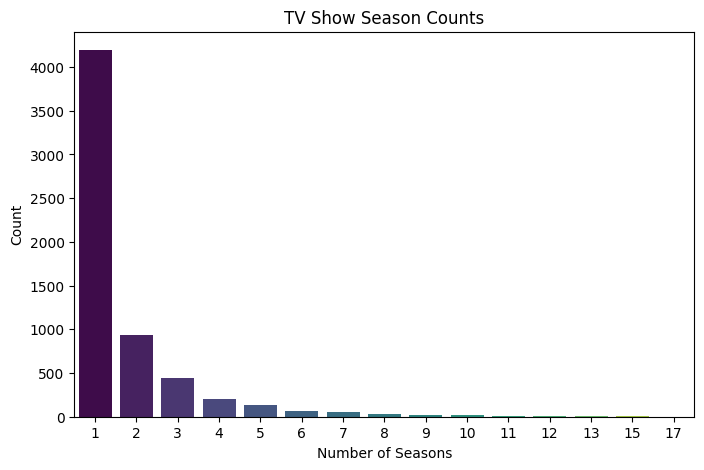

count    6111.000000
mean        1.718704
std         1.541964
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: int_duration (seasons), dtype: float64


In [18]:
sns.histplot(netflix_movies_exploded['int_duration (minutes)'], bins=30, kde=True)
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()

print(netflix_movies_exploded['int_duration (minutes)'].describe())

plt.figure(figsize=(8, 5))
sns.countplot(x='int_duration (seasons)', data=netflix_tv_exploded, hue= 'int_duration (seasons)', legend= False, palette= 'viridis')
plt.title('TV Show Season Counts')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')
plt.show()

print(netflix_tv_exploded['int_duration (seasons)'].describe())


Most movies on Netflix have durations clustered around 90–120 minutes. A few outliers exceed 200 minutes, which could be due to documentaries or extended editions. Some movies arae also just very long but on average they should fall between that 90-115ish minute range with a mean of 106 minutes. On the other hand, most TV shows are 1 seasons long with a mean of 1.7 seasons (1.7 seasons not normally possible its just skew from other data points that are not 1; we can say that on average most shows on Netflix have 1 season)

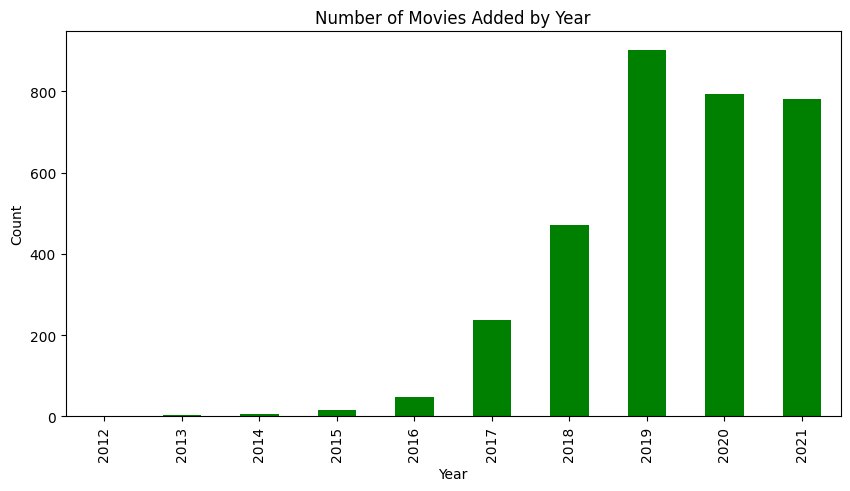

year_added
2012      2
2013      3
2014      7
2015     17
2016     49
2017    237
2018    472
2019    902
2020    793
2021    781
Name: count, dtype: int64

In [19]:
netflix_movies_exploded['year_added'] = netflix_movies_exploded['date_added'].dt.year

netflix_movies_exploded['year_added'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5), color= 'Green')
plt.title('Number of Movies Added by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

netflix_movies_exploded['year_added'].value_counts().sort_index()

We can see from the graph that there was a sharp increase in movies added to Netflix after 2016 to about 2020, the highest number of movies added being in 2019 with a count of 902. The decrease after 2019 could be due to Covid-19 and the resulting production issues.

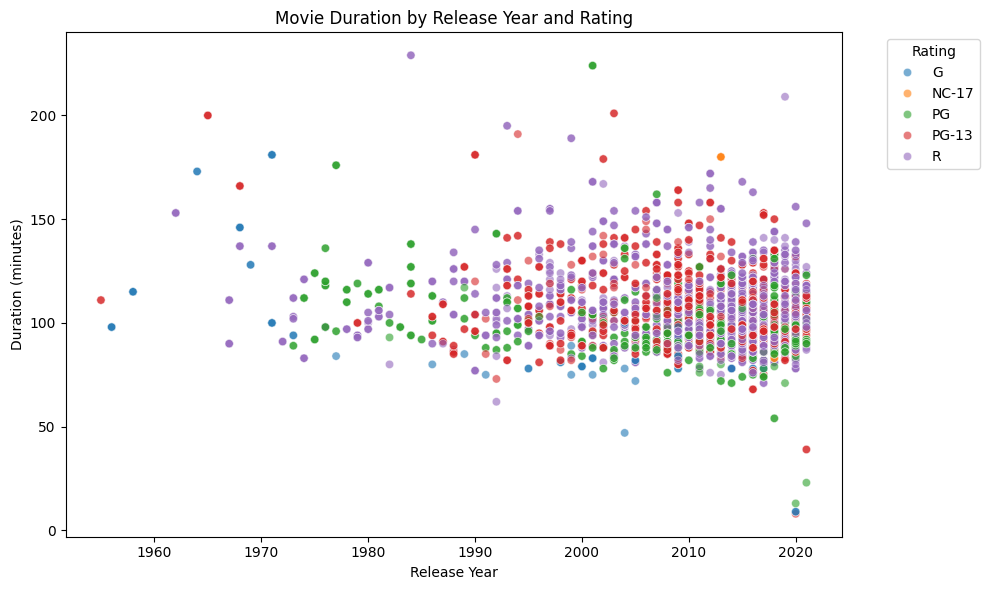

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=netflix_movies_exploded, x='release_year', y='int_duration (minutes)', hue='rating', alpha=0.6)
plt.title('Movie Duration by Release Year and Rating')
plt.xlabel('Release Year')
plt.ylabel('Duration (minutes)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Ratings are fairly evenly distributed post-1990 and there’s no clear dominance of a specific rating in terms of duration. PG-13 and R are the most frequent, but G, PG, and even NC-17 are represented, all sticking mostly within the 90–130 minute range. There's also more duration variation among the Ratings in the earlier decades (pre 1980).

C:\Users\Nason\AppData\Local\Temp\ipykernel_7816\986448099.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = top_movies.pivot_table(


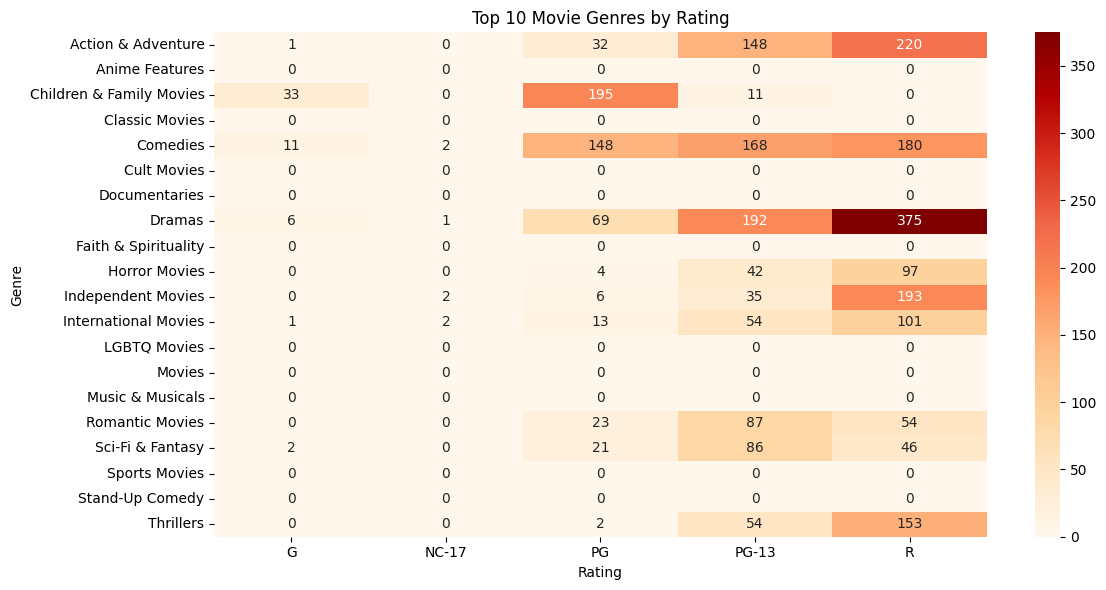

In [21]:


#top ten genres
top_movie_genres = netflix_movies_exploded['genre'].value_counts().nlargest(10).index

# only movies that are top movies/top ten
top_movies = netflix_movies_exploded[netflix_movies_exploded['genre'].isin(top_movie_genres)]

# pivot table to create a heatmap
heatmap_data = top_movies.pivot_table(
    index='genre',
    columns='rating',
    values='show_id',  # assuming each row has a unique show_id or use any constant field
    aggfunc='count',
    fill_value=0
)

# heatmap plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='OrRd')
plt.title('Top 10 Movie Genres by Rating')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

plt.show()

Looking at the heatmap, Dramas are clearly the most common genre overall, especially in the R and PG-13 categories. Comedies are pretty evenly split between ratings of PG-13 and R, while Children & Family Movies are almost entirely PG, which makes sense. Independent and International Movies show up mostly under R, maybe because they deal with more mature themes. In general, G and PG are for family stuff, while PG-13 and R are where you see most of the adult-focused genres like thrillers and romance

### Mandatory Questions
* are TV shows trending toward longer or shorter seasons
* compare average release year or genre diversity or number of entries
* Explain how genres have shifted over time

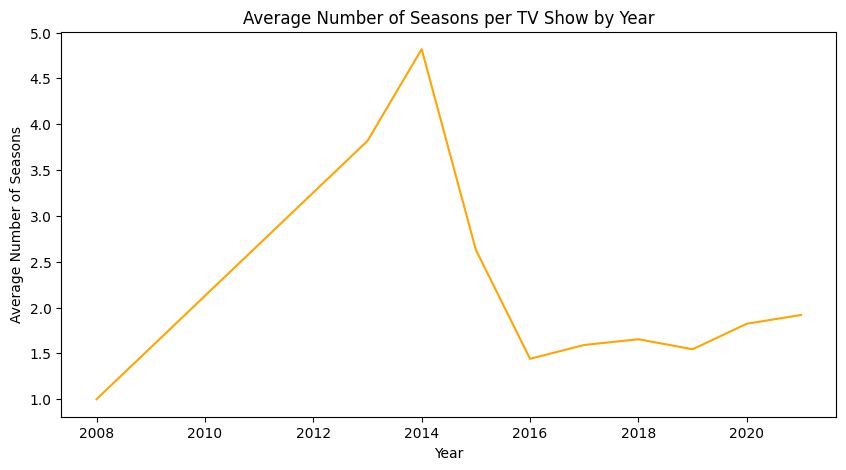

In [22]:
## tv shows over time
netflix_tv_exploded['year_added'] = netflix_tv_exploded['date_added'].dt.year
tv_season_trend = netflix_tv_exploded.groupby('year_added')['int_duration (seasons)'].mean()
tv_season_trend.plot(title='Average Number of Seasons per TV Show by Year', color= 'orange',  figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Average Number of Seasons')
plt.show()


From this graph, we can see that there is a strong upward trend from 2008-2014, then we experience a sharp decline in average tv show season length after 2014 with a short, bumpy, varying slope from 2016-2020. From this, over time I would say that the average tv show length does increase over time, although it is to be noted that there is a sharp drop from 2014 to 2016 but now there is a slight positive slope of increasing average tv show length from 2016 to 2021.

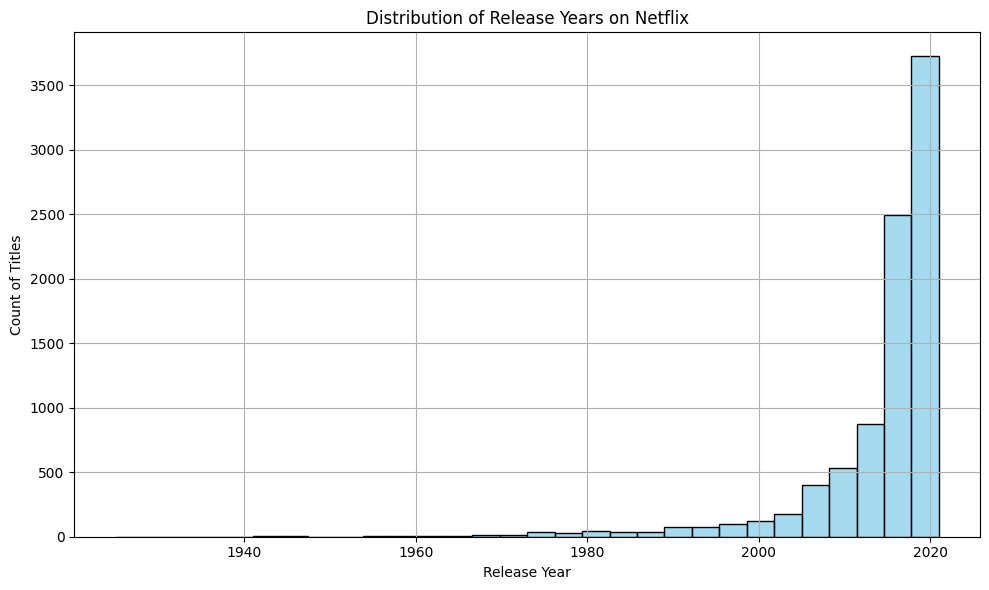

Average Release Year: 2014.0
Median Release Year: 2017.0
Movies - Median Release Year: 2016
TV Shows - Median Release Year: 2018


In [23]:
##plot release years total on netflix
plt.figure(figsize=(10, 6))
sns.histplot(data=netflix, x='release_year', bins=30, color='skyblue', kde=False)
plt.title('Distribution of Release Years on Netflix')
plt.xlabel('Release Year')
plt.ylabel('Count of Titles')
plt.grid(True)
plt.tight_layout()
plt.show()

# numeric form
netflix['release_year'] = pd.to_numeric(netflix['release_year'], errors='coerce')

## Average release year
average_release_year = netflix['release_year'].mean()
print("Average Release Year:", round(average_release_year, 0))

# median release year total
median_release_year = netflix['release_year'].median()
print("Median Release Year:", median_release_year)

# movies
movies = netflix[netflix['type'] == 'Movie']
med_release_year_movies = movies['release_year'].median()

# tv shows
tv_shows = netflix[netflix['type'] == 'TV Show']
med_release_year_tv = tv_shows['release_year'].median()

print(f"Movies - Median Release Year: {int(med_release_year_movies)}")
print(f"TV Shows - Median Release Year: {int(med_release_year_tv)}")



The average release year is 2014 (when rounded). However, I created a histogram just to see what the shape of the distribution looks like and it is left skewed so I think median would be a better determiner of "average" release year. So for both movies and tv shows the average release year is 2017, and indivudally for movies it is 2016 and for TV shows it is 2018.

<Figure size 1400x700 with 0 Axes>

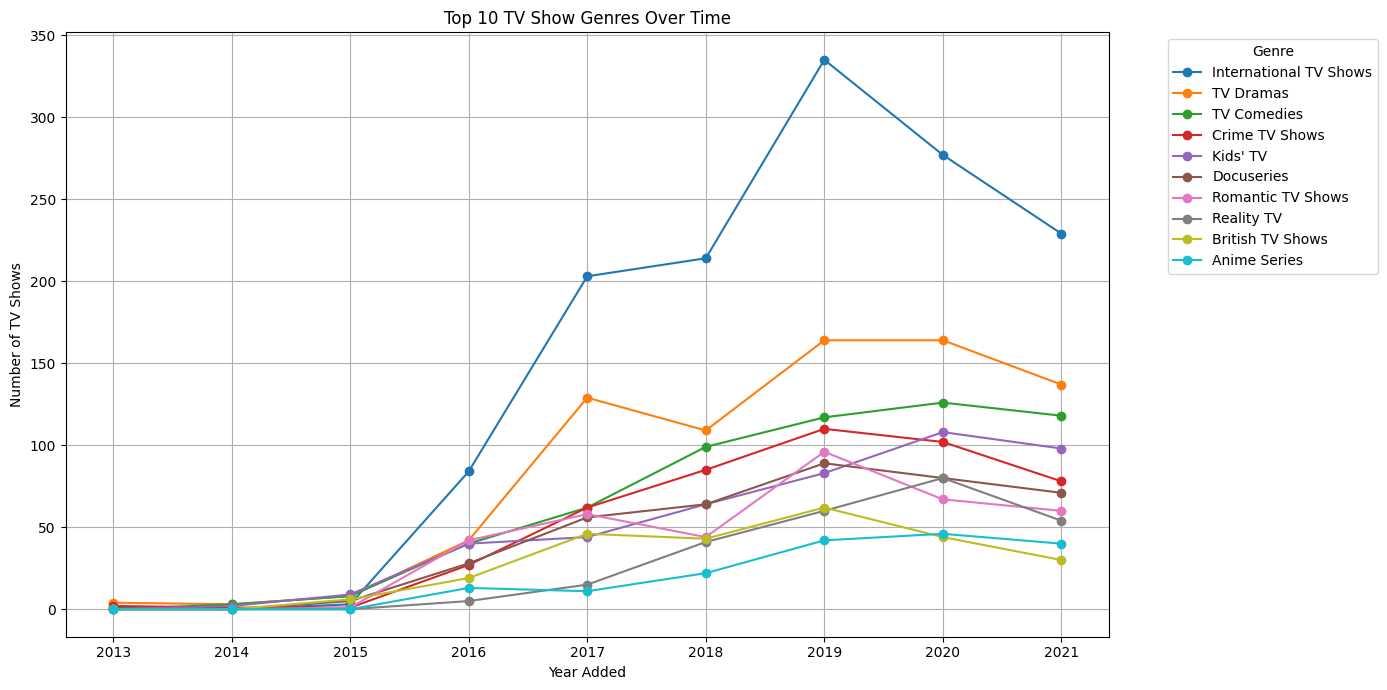

<Figure size 1400x700 with 0 Axes>

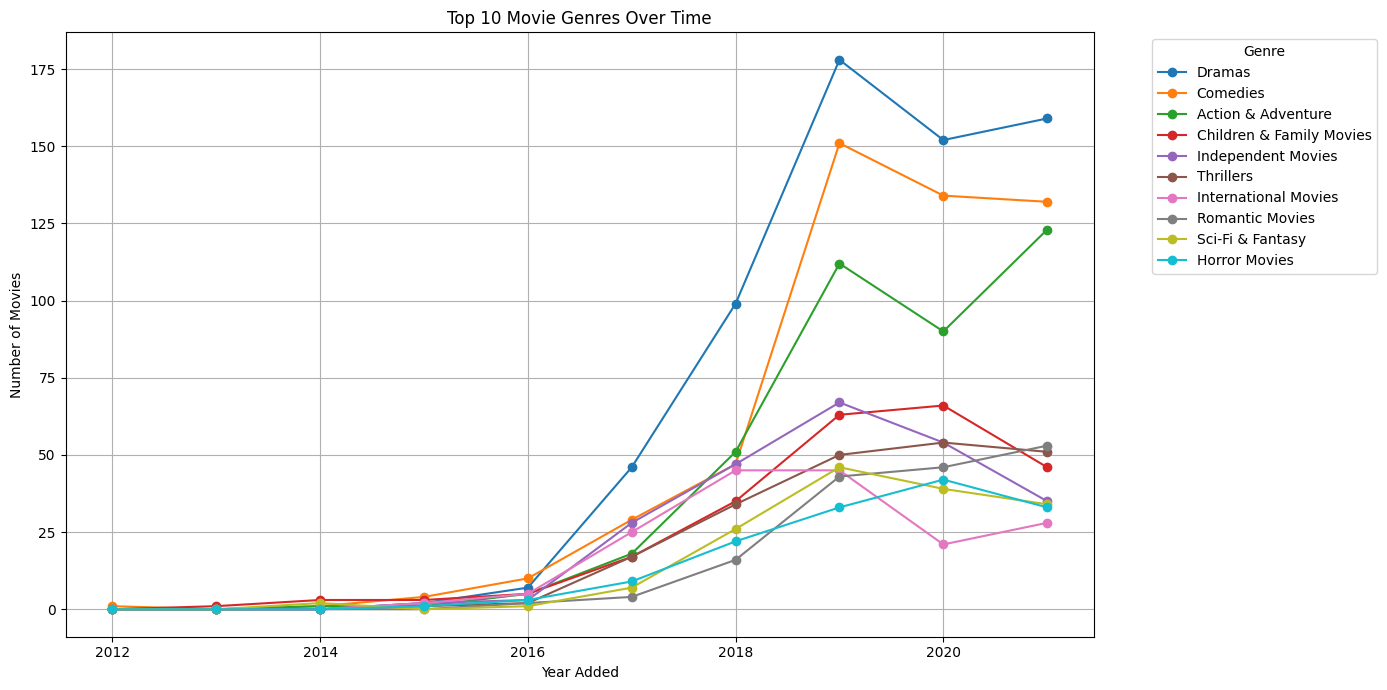

                           Genre  TV Show Count (2012–2016)
0         International TV Shows                         88
1                      TV Dramas                         57
2                       Kids' TV                         51
3                    TV Comedies                         51
4              Romantic TV Shows                         43
5                     Docuseries                         33
6                 Crime TV Shows                         31
7               British TV Shows                         25
8            Science & Nature TV                         13
9                   Anime Series                         13
10         TV Action & Adventure                         10
11               Korean TV Shows                          9
12                  TV Thrillers                          7
13                     TV Horror                          7
14                  TV Mysteries                          7
15           TV Sci-Fi & Fantasy        

In [24]:
## How have genres shifted over time

netflix_tv_exploded['year_added'] = netflix_tv_exploded['date_added'].dt.year


# only top ten genres
top_tv_genres = netflix_tv_exploded['genre'].value_counts().nlargest(10).index
tv_top = netflix_tv_exploded[netflix_tv_exploded['genre'].isin(top_tv_genres)]

# Group by year and genre and then count
tv_genre_trend = tv_top.groupby(['year_added', 'genre'], observed= True).size().unstack(fill_value=0)

#remove zero columns tv drama kept showing
tv_genre_trend = tv_genre_trend[top_tv_genres]
tv_genre_trend = tv_genre_trend.loc[:, (tv_genre_trend != 0).any()]

# Plot
plt.figure(figsize=(14, 7))
tv_genre_trend.plot(marker='o', figsize=(14, 7))
plt.title('Top 10 TV Show Genres Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of TV Shows')
plt.grid(True)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#year from datetime
netflix_movies_exploded['year_added'] = netflix_movies_exploded['date_added'].dt.year

#top ten movie genre
top_movie_genres = netflix_movies_exploded['genre'].value_counts().nlargest(10).index
movie_top = netflix_movies_exploded[netflix_movies_exploded['genre'].isin(top_movie_genres)]

# Group by year and genre and count number of years
movie_genre_trend = movie_top.groupby(['year_added', 'genre'], observed= True).size().unstack(fill_value=0)

#top ten only and no zero columns
movie_genre_trend = movie_genre_trend[top_movie_genres]
movie_genre_trend = movie_genre_trend.loc[:, (movie_genre_trend != 0).any()]

# Plot
plt.figure(figsize=(14, 7))
movie_genre_trend.plot(marker='o', figsize=(14, 7))
plt.title('Top 10 Movie Genres Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#descriptive stats for 2012 - 2016 because I cannot tell from the graph
# Filter TV and Movie data between 2012–2016
tv_filtered = netflix_tv_exploded[(netflix_tv_exploded['year_added'] >= 2012) & (netflix_tv_exploded['year_added'] <= 2016)]
movie_filtered = netflix_movies_exploded[(netflix_movies_exploded['year_added'] >= 2012) & (netflix_movies_exploded['year_added'] <= 2016)]

# Get genre counts
tv_stats = tv_filtered['genre'].value_counts().rename_axis('Genre').reset_index(name='TV Show Count (2012–2016)')
movie_stats = movie_filtered['genre'].value_counts().rename_axis('Genre').reset_index(name='Movie Count (2012–2016)')

print(tv_stats)
print(movie_stats)



I used year_added to Netflix as it shows Netflix demand which could also represent their response to global demand for certain genres

For TV shows, international content has clearly been the biggest genre on Netflix since 2012. It really grows after 2016 and stays dominant through 2021, probably because Netflix started investing heavily in global content (like K-dramas and Spanish series). Other genres like TV Dramas, Comedies, and Kids' TV are also consistently high, but never surpass international shows. Crime, Romantic, and Documentary-style shows grow a lot post-2016, which could be explained by more interest in crime and niche storytelling.

For movies, the genre mix changes slower. From 2012 to 2016, Comedies, Dramas, and Family Movies are most common, but overall movie counts are low. After 2017, there's a big spike across all genres, but we see a big change especially in Dramas and Comedies, which is the highest, and Action & Adventure starts rising too. Netflix clearly expanded its movie options after 2016 as well with dramas now being the highest changing from the intial genre of comedy leading the pack.

(I generated decriptive stats because it is hard to see from just the graph, that is where I am getting my conclusions from for the years 2012-2016)